### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import nltk
import sympy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    classification_report
)

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import entropy
from nltk.sentiment import SentimentIntensityAnalyzer

### Import Data & Basic Inspection (Referenced from EDA)

In [4]:
df = pd.read_csv('playlist_revision_v05.txt', sep ='\t')
df.drop(columns = ['mau_premium_ratio','mau_previous_month_premium_ratio'],inplace = True)

In [5]:
df.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3,premium_mau_previous_month,premium_mau
0,spotify:user:25d04611ade7d93b279098dd90c2dcde:...,25d04611ade7d93b279098dd90c2dcde,0,0,0,2,3,1,1,3,...,6,"[""eclectronic""]",Electronica,Alternative,Dance & House,Sensual,Excited,Brooding,1.0,1.0
1,spotify:user:a99297eb43f794a785a32258cc5320e7:...,a99297eb43f794a785a32258cc5320e7,0,0,0,0,2,0,0,2,...,26,"[""party"", ""woodside""]",Pop,Latin,Rap,Excited,Energizing,Defiant,0.0,2.0
2,spotify:user:294f08499afea11c56ddf92ab3ce6f56:...,294f08499afea11c56ddf92ab3ce6f56,5,5,1,3,5,3,1,9,...,617,"[""five"", ""hours""]",Alternative,Electronica,Pop,Excited,Aggressive,Urgent,2.0,3.0
3,spotify:user:acfea3b5d4a4b8fefa6c8605738788e8:...,acfea3b5d4a4b8fefa6c8605738788e8,30,30,1,1,2,2,1,3,...,5,"[""summertime""]",Alternative,Rap,Pop,Defiant,Excited,Energizing,2.0,2.0
4,spotify:user:46f8f6c970f7a68ec67fe69514e9b182:...,46f8f6c970f7a68ec67fe69514e9b182,0,0,0,1,2,2,1,6,...,9,"[""latino"", ""greatest"", ""hits""]",Pop,R&B,Blues,Energizing,Lively,Fiery,2.0,1.0


In [7]:
#statistical analysis (numerical columns)
df.describe()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,premium_mau_previous_month,premium_mau
count,4.272760e+05,4.272760e+05,427276.000000,427276.000000,4.272760e+05,4.272760e+05,427276.000000,4.272760e+05,427276.000000,427276.000000,427276.000000,427276.000000,427276.000000,4.272760e+05,427276.000000,427275.000000,4.272750e+05
mean,7.212229e+01,4.449239e+01,4.299673,21.192740,6.440589e+01,5.669391e+01,12.560825,1.454201e+02,2.734268,194.724101,2.979077,81.027820,85.269519,1.250349e+03,116.974953,37.095646,3.518560e+01
std,6.316762e+03,3.673820e+03,349.535428,1574.886035,4.619766e+03,3.741111e+03,1208.712012,9.042585e+03,199.744978,575.081233,39.460309,126.723869,131.827612,1.035363e+05,256.382438,2359.007039,2.474932e+03
min,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000e+00,0.000000,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,1.000000e+00,1.000000,2.000000e+00,0.000000,34.000000,0.000000,16.000000,17.000000,3.200000e+01,7.000000,0.000000,1.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,2.000000e+00,1.000000,3.000000e+00,0.000000,80.000000,0.000000,44.000000,46.000000,8.400000e+01,32.000000,1.000000,2.000000e+00
75%,1.000000e+01,6.000000e+00,1.000000,2.000000,3.000000e+00,3.000000e+00,2.000000,7.000000e+00,0.000000,185.000000,0.000000,98.000000,103.000000,2.160000e+02,110.000000,3.000000,2.000000e+00
max,2.629715e+06,1.513237e+06,152929.000000,669966.000000,1.944150e+06,1.478684e+06,578391.000000,3.455406e+06,86162.000000,79984.000000,9117.000000,5226.000000,6397.000000,4.249733e+07,25904.000000,987995.000000,1.012068e+06


In [8]:
# check for null counts & datatype discrepancies
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427276 entries, 0 to 427275
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   playlist_uri                427276 non-null  object 
 1   owner                       427276 non-null  object 
 2   streams                     427276 non-null  int64  
 3   stream30s                   427276 non-null  int64  
 4   dau                         427276 non-null  int64  
 5   wau                         427276 non-null  int64  
 6   mau                         427276 non-null  int64  
 7   mau_previous_month          427276 non-null  int64  
 8   mau_both_months             427276 non-null  int64  
 9   users                       427276 non-null  int64  
 10  skippers                    427276 non-null  int64  
 11  owner_country               427276 non-null  object 
 12  n_tracks                    427276 non-null  int64  
 13  n_local_tracks

In [13]:
df.isnull().sum()

playlist_uri                  0
owner                         0
streams                       0
stream30s                     0
dau                           0
wau                           0
mau                           0
mau_previous_month            0
mau_both_months               0
users                         0
skippers                      0
owner_country                 0
n_tracks                      0
n_local_tracks                0
n_artists                     0
n_albums                      0
monthly_stream30s             0
monthly_owner_stream30s       0
tokens                        0
genre_1                       0
genre_2                       0
genre_3                       0
mood_1                        0
mood_2                        0
mood_3                        0
premium_mau_previous_month    1
premium_mau                   1
dtype: int64

Only one null value in two columns - we can **drop** these.

In [16]:
df.dropna(inplace=True)

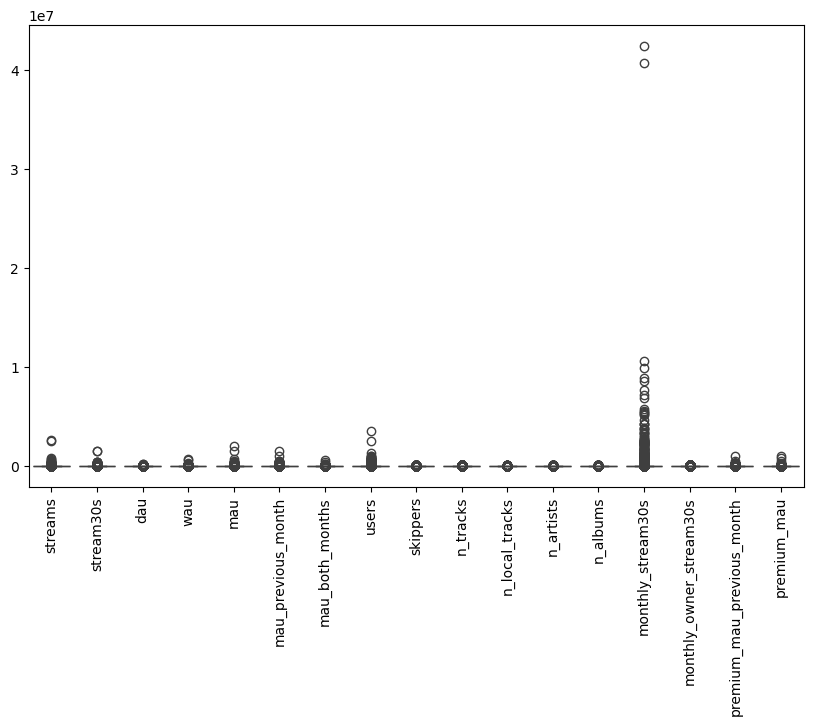

In [17]:
#Box Plot - Obsering Range similarities and outliers

plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

Outliers seem to be present in almost every numerical column. We will address two of these (monthly_stream30s & n_tracks) right away. For others, instead of employing usual techniques like IQR/Z-Score/Isokation Foresets, we will handle these outliers **individually**, depending on our definition of success. (Turns out, these outliers are rather important, and do not hamper the quality of our ensemble model).

In [19]:
df = df[(df['monthly_stream30s'] <= 500)&(df['n_tracks'] <= 500)]

In [21]:
df.nunique()

playlist_uri                  345560
owner                         272438
streams                          250
stream30s                        166
dau                               23
wau                               59
mau                              141
mau_previous_month               172
mau_both_months                   25
users                            353
skippers                          26
owner_country                      1
n_tracks                         500
n_local_tracks                   254
n_artists                        448
n_albums                         471
monthly_stream30s                499
monthly_owner_stream30s          501
tokens                        168494
genre_1                           26
genre_2                           26
genre_3                           26
mood_1                            27
mood_2                            27
mood_3                            27
premium_mau_previous_month       140
premium_mau                       90
d

**Owner Country** column is univariate. We can drop it.

In [24]:
df.drop(columns = ['owner_country'], inplace= True)

### Feature Engineering

#### Function Definitions

In [28]:
def get_vader_sentiment(mood):
    """
    Computes the VADER sentiment score for a given text. (Used to capture the sentiment in the "Mood" columns of the dataset)

    Parameters:
    mood (str): The input text to analyze. If mood is "-", returns None.

    Returns:
    float or None: The compound sentiment score, ranging from -1 (negative) to 1 (positive),
                   or None if the input is "-".
    """
    if mood == "-":
        return None
    return sia.polarity_scores(mood)["compound"]

In [30]:
def compute_sentiment(row, weights = [0.5, 0.3, 0.2]):
    """
    Computes a weighted sentiment score based on available mood sentiment values. (Used to calculate the weighted average of the sentiments 
    of the "Mood")

    Parameters:
    row (pd.Series): A row from a DataFrame containing sentiment scores for different moods.

    Returns:
    float: The weighted sum of sentiment scores. Returns 0 if all values are None.
    """
    weights = weights
    
    sentiments = [row["mood_1_sentiment"], row["mood_2_sentiment"], row["mood_3_sentiment"]]
    sentiments = [s for s in sentiments if s is not None] 
    
    return sum(w * s for w, s in zip(weights, sentiments)) if sentiments else 0  

In [32]:
def compute_mix(row):
    """
    Computes the range (max - min) of sentiment scores for a given row.

    Parameters:
    row (pd.Series): A row from a DataFrame containing sentiment scores for different moods.

    Returns:
    float: The difference between the highest and lowest sentiment scores.
           Returns 0 if all values are None.
    """
    sentiments = [row["mood_1_sentiment"], row["mood_2_sentiment"], row["mood_3_sentiment"]]
    sentiments = [s for s in sentiments if s is not None]  # Filter out None values
    
    return max(sentiments, default=0) - min(sentiments, default=0) if sentiments else 0

In [34]:
def extract_topics(df, text_cols, n_topics, topic_prefix, top_k_words=10, retain_top_topic=True):
    """
    Applies LDA topic modeling on specified text columns and adds topic probabilities to the DataFrame.
    Also returns the top-k words for each topic, and optionally retains the top topic.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    text_cols (str or list of str): Column(s) containing text data.
    n_topics (int): Number of topics for LDA.
    topic_prefix (str): Prefix for the topic columns in the output DataFrame.
    top_k_words (int): Number of top words to return for each topic.
    retain_top_topic (bool): If True, retains the top topic as a single column in the DataFrame.

    Returns:
    tuple: (Updated DataFrame, Dictionary of top-k words for each topic)
    """
    if isinstance(text_cols, str):
        text_cols = [text_cols]

    # Step 1: Create a single text column
    temp_col = f"{topic_prefix}_text"
    df[temp_col] = df[text_cols].apply(lambda x: " ".join(val for val in x if val != "-"), axis=1)

    # Step 2: Convert text to bag-of-words representation
    vectorizer = CountVectorizer(stop_words="english")
    text_matrix = vectorizer.fit_transform(df[temp_col])

    # Step 3: Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topic_matrix = lda.fit_transform(text_matrix)

    # Step 4: Add topic probabilities to DataFrame
    df[[f"{topic_prefix}_topic_{i}" for i in range(n_topics)]] = topic_matrix

    # Step 5: Retain the top topic (optional)
    if retain_top_topic:
        df[f"{topic_prefix}_topic"] = topic_matrix.argmax(axis=1)

    # Step 6: Extract top-k words for each topic
    feature_names = np.array(vectorizer.get_feature_names_out())
    topic_word_dict = {
        f"Topic {i}": feature_names[np.argsort(lda.components_[i])[-top_k_words:][::-1]].tolist()
        for i in range(n_topics)
    }

    # Step 7: Drop original text columns, temp column, and individual topic columns
    df.drop(columns=text_cols + [temp_col] + [f"{topic_prefix}_topic_{i}" for i in range(n_topics)], inplace=True)

    return df, topic_word_dict

##### Mood Columns: Calculating "sentiment_score"

*mood_count* was also a part of the model at first, but was removed in favour of *mood_diversity.*

In [37]:
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each mood column
df["mood_1_sentiment"] = df["mood_1"].apply(get_vader_sentiment)
df["mood_2_sentiment"] = df["mood_2"].apply(get_vader_sentiment)
df["mood_3_sentiment"] = df["mood_3"].apply(get_vader_sentiment)

df["sentiment_score"] = df.apply(compute_sentiment, axis=1)
df["mood_diversity"] = df.apply(compute_mix, axis=1)

df.drop(columns=["mood_1", "mood_2", "mood_3", "mood_1_sentiment", "mood_2_sentiment", "mood_3_sentiment"], inplace=True)

In [38]:
df.fillna(0, inplace=True)

##### Genre Columns & Tokens: Topic Modelling

For genre, embeddings like GloVe/Word2VEC were also tested, but Topic Modeling helps more with interpretability.

In [40]:
#Counts of Genres and Tokens

df["genre_count"] = df[["genre_1", "genre_2", "genre_3"]].apply(lambda x: sum(x != "-"), axis=1)
df["token_count"] = df["tokens"].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
df.loc[df['tokens'] == '[]', 'token_count'] = 0

In [41]:
#Tokens
df, token_top_words = extract_topics(df, "tokens", n_topics=5, topic_prefix="token", top_k_words=5)

In [42]:
#Genres
df, genre_top_words = extract_topics(df, ["genre_1", "genre_2", "genre_3"], n_topics=3, topic_prefix="genre", top_k_words=3)

In [43]:
token_top_words

{'Topic 0': ['music', 'songs', 'mix', 'love', 'rock'],
 'Topic 1': ['country', 'good', 'worship', 'yoga', 'favorites'],
 'Topic 2': ['party', 'jams', 'music', 'september', 'hits'],
 'Topic 3': ['summer', 'chill', 'workout', 'dance', 'music'],
 'Topic 4': ['playlist', 'new', 'best', 'rap', 'songs']}

In [44]:
genre_top_words

{'Topic 0': ['house', 'dance', 'rock'],
 'Topic 1': ['rock', 'indie', 'dance'],
 'Topic 2': ['pop', 'rap', 'latin']}

The Column "Owner" cotains anonymized owner names, other than spotify. We can make another binary column "spotify_owned" from this information. (Since the number of spotify owned playlists are still very few in comparison to others, it is unlikely to contribute much to the model. However, we may still be able to find some trends in this later on.)

##### Owner Data

In [47]:
df["spotify_owned"] = df["owner"].apply(lambda x: 1 if x.lower() == "spotify" else 0)

An Owner of a spotify playlist may be an artist/celebrity or another "specialist" in playlist creation. The *experience* of a playlist may tell us valuable information. To capture the number of playlists a specific owner has created, we will created another column called "playlists_owner_created". After this, we can drop the "owner" and "playlist_uri" columns, as they now serve just as unnamed entities.

In [51]:
df["playlists_owner_created"] = df.groupby("owner")["playlist_uri"].transform("nunique")

In [52]:
df.drop(columns = ['owner'], inplace=True)

In [53]:
df.drop(columns = ['playlist_uri'], inplace=True)

In [54]:
df.isnull().sum()

streams                       0
stream30s                     0
dau                           0
wau                           0
mau                           0
mau_previous_month            0
mau_both_months               0
users                         0
skippers                      0
n_tracks                      0
n_local_tracks                0
n_artists                     0
n_albums                      0
monthly_stream30s             0
monthly_owner_stream30s       0
premium_mau_previous_month    0
premium_mau                   0
sentiment_score               0
mood_diversity                0
genre_count                   0
token_count                   0
token_topic                   0
genre_topic                   0
spotify_owned                 0
playlists_owner_created       0
dtype: int64

In [55]:
#Storing a copy of our processed/engineeried data. We will need this frequently.
base_df = df.copy()

### Modeling

#### Function Definitions

In [75]:
def train_and_evaluate(df, drop_cols, model='RF', scaling=True, class_weights={0: 1, 1: 1.5}):
    """
    Train a classification model and evaluate performance.

    Parameters:
    df (DataFrame): The input dataframe containing features and target.
    drop_cols (list): List of columns to drop before training.
    model (str): Model type to use ('RF' for RandomForest, 'Logistic' for LogisticRegression, 'XGB' for XGBoost).
    scaling (bool, optional): Whether to apply standard scaling to numerical features. Defaults to True.
    class_weights (dict, optional): Dictionary of class weights for handling class imbalance. Defaults to None.

    Returns:
    str: Classification report summarizing model performance.
    """
    df = df.drop(columns=drop_cols)
    
    X = df.drop(columns=["success"])
    y = df["success"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if scaling:
        numerical_columns = X_train.select_dtypes(include=['number']).columns
        scaler = StandardScaler()
        X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
        X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
    
    if model == "RF":
        model_instance = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight=class_weights)
    elif model == "Logistic":
        model_instance = LogisticRegression(random_state=42, class_weight=class_weights)
    elif model == "XGB":
        model_instance = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=class_weights[1] if class_weights else None)
    else:
        raise ValueError("Unsupported model type. Choose from 'RF', 'Logistic', or 'XGB'.")
    
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)

    print(classification_report(y_test, y_pred))
    
    return classification_report(y_test, y_pred), model_instance, X_train

In [77]:
def plot_feature_importance(model, X_train, palette=None, figsize=(10, 6), ascending=False):
    """
    Plots feature importance for a trained model.

    Parameters:
    ----------
    model : object
        A trained model with a `feature_importances_` attribute (e.g., RandomForest, XGBoost).
    
    X : DataFrame
        The feature matrix used to train the model.
    
    palette : list, optional (default=None)
        A list of colors for the bar plot. If None, default Seaborn colors are used.
    
    figsize : tuple, optional (default=(10, 6))
        The figure size for the plot.
    
    ascending : bool, optional (default=False)
        If True, sorts feature importance in ascending order; otherwise, sorts in descending order.
    
    Returns:
    -------
    None
        Displays the feature importance plot.
    """

    # Extract feature importances
    importances = model.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame for visualization
    feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=ascending)

    # Set default color palette if none provided
    if palette is None:
        palette = spotify_green = ["#1DB954", "#1ed760", "#1aa34a"]

    # Plot feature importances
    plt.figure(figsize=figsize)
    sns.barplot(x="Importance", y="Feature", data=feat_importance_df, palette=palette)
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

    return feat_importance_df

In [79]:
def compute_shap_explanations(model, X_train, num_samples=75, random_seed=None, local=False, row_num=0):
    """
    Computes SHAP explanations using KernelExplainer and provides global and optional local interpretability.

    Parameters:
    ----------
    model : object
        A trained model that supports `predict_proba` (e.g., RandomForest, XGBoost, Logistic Regression).

    X_train : DataFrame
        The training feature matrix.

    num_samples : int, optional (default=75)
        Number of samples to use for SHAP explanation.

    random_seed : int, optional (default=None)
        Random seed for sampling reproducibility.

    local : bool, optional (default=False)
        If True, generates a SHAP waterfall plot for a single instance.

 fe   row_num : int, optional (default=0)
        The row index of the instance to visualize if `local=True`.

    Returns:
    -------
    None
        Displays SHAP summary plot and optionally a waterfall plot.
    """

    # Sample data for SHAP analysis
    X_sampled = X_train.sample(n=num_samples, random_state=random_seed or np.random.randint(10000))

    # Create SHAP explainer using KernelExplainer
    explainer = shap.KernelExplainer(model.predict_proba, X_sampled)

    # Compute SHAP values
    shap_values_train = explainer.shap_values(X_sampled)

    # Generate SHAP summary plot
    shap.summary_plot(shap_values_train[:, :, 1], X_sampled)

    # If local is True, generate a SHAP waterfall plot
    if local:
        shap.plots.waterfall(
            shap.Explanation(
                values=shap_values_train[row_num, :, 1], 
                base_values=explainer.expected_value[1], 
                data=X_sampled.iloc[row_num]
            )
        )

In [81]:
def plot_shap_means(model, X_train, columns = ["n_tracks", "n_albums", "n_artists"], num_bins=5, fill = False, random_state=44):
    """
    This function calculates the mean SHAP values for specified columns in the training data, 
    groups the data into bins, and plots the mean SHAP values for each bin.

    Parameters:
    -----------
    model : object
        The trained model that has a `predict_proba` method for making predictions.
    
    X_train : pandas.DataFrame
        The training data used to calculate SHAP values and create bins.
    
    columns : list of str
        The list of column names in `X_train` for which SHAP values and binning will be calculated.
    
    num_bins : int, optional, default=5
        The number of bins to split each column into. Default is 5 bins.
    
    random_state : int, optional, default=44
        The random state to ensure reproducibility of the sampling process.
    
    Returns:
    --------
    shap_means : pandas.DataFrame
        A DataFrame containing the mean SHAP values for each bin and each column.
    """
    
    # Sample the training data
    X_sampled = X_train.sample(n=100, random_state=random_state)
    
    # Initialize an empty DataFrame to store the results
    result = pd.DataFrame()

    for column in columns:
        # Create the bins with integer labels
        check = pd.qcut(X_sampled[column], q=num_bins, labels=range(1, num_bins + 1), duplicates="drop")

        # Get the bin ranges (intervals)
        bin_ranges = pd.qcut(X_sampled[column], q=num_bins, duplicates="drop")

        # Round the bin ranges to the nearest integers
        bin_ranges_rounded = bin_ranges.apply(lambda x: f"({int(x.left)}, {int(x.right)})")

        # Add the columns to the result DataFrame
        result[column] = X_sampled[column]
        result[f'{column}_bin_label'] = check
        result[f'{column}_bin_range'] = bin_ranges_rounded

    # Assuming the model has a `predict_proba` method for classification
    explainer = shap.KernelExplainer(model.predict_proba, X_sampled)
    shap_values_train = explainer.shap_values(X_sampled)
    shap_values_class = shap_values_train[:,:,1]

    shap_means = pd.DataFrame()

    for column in columns:
        # Group by the bin label
        bin_labels = result[f'{column}_bin_label']
        bin_ranges = result[f'{column}_bin_range']

        # Create a dictionary to store mean SHAP values for each bin
        mean_shap_values = {}

        # Loop through unique bin labels
        for bin_label in bin_labels.unique():
            # Filter data for the current bin
            bin_mask = bin_labels == bin_label
            bin_shap_values = shap_values_class[bin_mask]

            # Calculate the mean SHAP value for this bin
            mean_shap_values[bin_label] = bin_shap_values.mean(axis=0).mean()  # Mean across features

        # Store the mean SHAP values for the current column
        shap_means[column] = [mean_shap_values[label] for label in bin_labels]

        # Create a dictionary mapping bin labels to their bin range
        bin_label_to_range = {label: range for label, range in zip(bin_labels.unique(), bin_ranges.unique())}

        # Sort bin ranges and corresponding mean SHAP values
        sorted_bin_ranges = sorted(bin_label_to_range.items(), key=lambda x: x[0])
        sorted_labels = [x[0] for x in sorted_bin_ranges]
        sorted_bin_ranges = [x[1] for x in sorted_bin_ranges]
        sorted_mean_shap_values = [mean_shap_values[label] for label in sorted_labels]

        # Plot the mean SHAP values for each bin
        plt.figure(figsize=(10, 6))

        # Create the shaded area under the curve
        if fill:
            plt.fill_between(sorted_bin_ranges, sorted_mean_shap_values, alpha=0.3, color='blue')

        # Plot the scatter points
        plt.scatter(sorted_bin_ranges, sorted_mean_shap_values, color='blue', label='Mean SHAP Values')

        # Title and labels
        plt.title(f'Mean SHAP Values for {column}')
        plt.xlabel('Bin Range')
        plt.ylabel('Mean SHAP Value')

        # Optional: Adjust x-ticks and rotate if needed
        plt.xticks(sorted_bin_ranges)

        # Display the plot
        plt.show()

    return shap_means

In [83]:
def oversample_with_smote(df, target_col="success", random_state=42):
    """
    Applies SMOTE to oversample the minority class.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    target_col (str): Name of the target column (default is "success")
    random_state (int): Random state for reproducibility
    
    Returns:
    pd.DataFrame: Oversampled DataFrame
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_col] = y_resampled
    
    return df_resampled

### Implementation

#### Streaming-based success

Definition a): A playlist is successful if it has a **high** number of streams.

In [101]:
df = base_df.copy()

df["stream_score"] = 0.50*df["stream30s"] + 0.20*df["streams"] + 0.20*df["monthly_stream30s"] + 0.10*df["monthly_owner_stream30s"]

threshold = df["stream_score"].quantile(0.65)
df["success"] = (df["stream_score"] > threshold).astype(int)

drop_cols = ['streams', 'stream_score', 'stream30s', 'dau', 'wau', 'mau', 'mau_previous_month', 'monthly_stream30s', 'users', 
        'monthly_owner_stream30s', 'mau_both_months', 'premium_mau_previous_month', 'premium_mau', 'skippers']

In [105]:
#Considering correlations
consider_features = [col for col in df.columns if col not in drop_cols]

# Calculate Pearson and Spearman correlations with the target ('success')
pearson_corr = df[consider_features].corr(method='pearson')['success']
spearman_corr = df[consider_features].corr(method='spearman')['success']

# Combine results into a DataFrame
correlation_results = pd.DataFrame({'Pearson': pearson_corr, 'Spearman': spearman_corr})
print(correlation_results)

                          Pearson  Spearman
n_tracks                 0.219722  0.245117
n_local_tracks           0.023615  0.039142
n_artists                0.191252  0.192750
n_albums                 0.201951  0.210309
sentiment_score          0.002748 -0.000294
mood_diversity          -0.006964 -0.004444
genre_count              0.065719  0.068458
token_count             -0.023352 -0.024491
token_topic             -0.003893 -0.003989
genre_topic             -0.004141 -0.003896
spotify_owned           -0.000594 -0.000594
playlists_owner_created -0.075964 -0.075489
success                  1.000000  1.000000


**Interpretation:**

Most features show weak or near-zero correlations with the target success, except for n_tracks, n_artists, and n_albums, which show modest positive correlations. The weak correlations suggest the relationships between the features and the target may not be strictly linear.

**Model Selection:**

Given the weak and potentially nonlinear relationships, **non-linear models like Random Forests** would be a better choice as they can capture complex patterns and interactions between features.

In [109]:
report, model, X_train = train_and_evaluate(df, drop_cols, scaling=False)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     46215
           1       0.49      0.49      0.49     24513

    accuracy                           0.65     70728
   macro avg       0.61      0.61      0.61     70728
weighted avg       0.65      0.65      0.65     70728



In [115]:
#Hyperparameter Tuning
df = base_df.copy()

df["stream_score"] = 0.50*df["stream30s"] + 0.20*df["streams"] + 0.20*df["monthly_stream30s"] + 0.10*df["monthly_owner_stream30s"]

threshold = df["stream_score"].quantile(0.65)
df["success"] = (df["stream_score"] > threshold).astype(int)

df = df.drop(columns=drop_cols)
    
X = df.drop(columns=["success"])
y = df["success"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depth_values = range(5,20) #could be modified if we see scope of improvement

train_scores = []
test_scores = []

for depth in max_depth_values:
    rf_model = RandomForestClassifier(max_depth = depth, n_estimators = 20, random_state = 42)
    rf_model.fit(X_train, y_train)

    train_accuracy = accuracy_score(y_train,rf_model.predict(X_train))
    test_accuracy = accuracy_score(y_test,rf_model.predict(X_test))

    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy) 

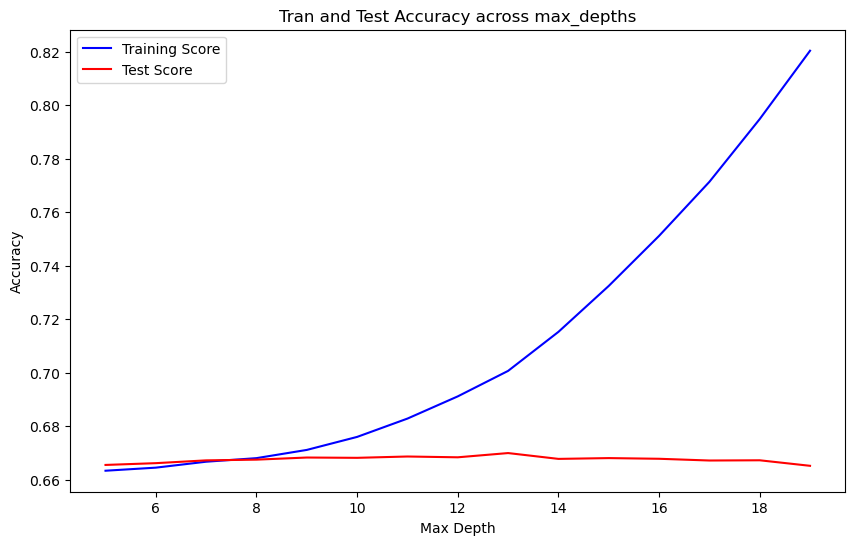

In [117]:
plt.figure(figsize = (10,6))
plt.plot(max_depth_values, train_scores, label = 'Training Score', color='blue')
plt.plot(max_depth_values, test_scores, label = 'Test Score', color='red')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Tran and Test Accuracy across max_depths')
plt.legend()
plt.show()

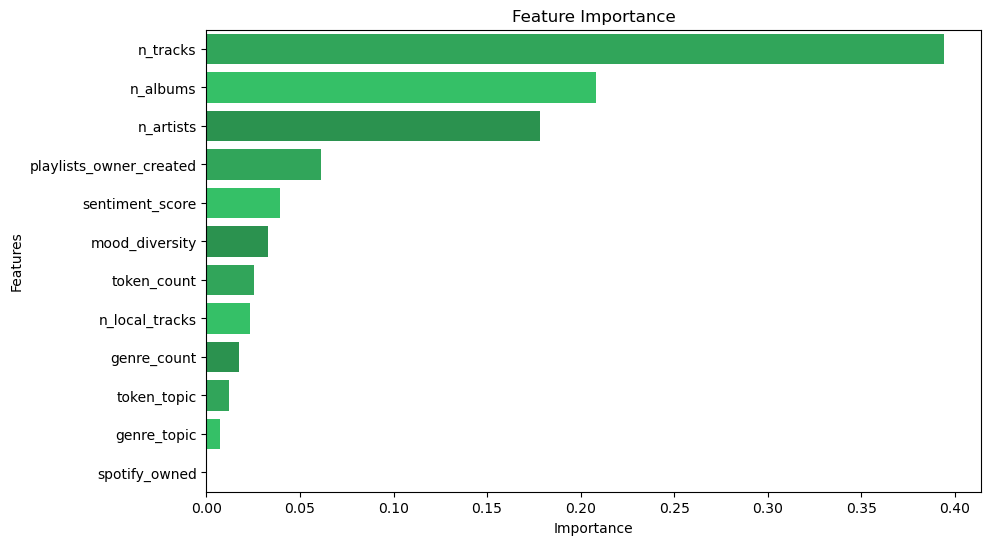

In [141]:
feat_df = plot_feature_importance(model, X_train)

  0%|          | 0/75 [00:00<?, ?it/s]

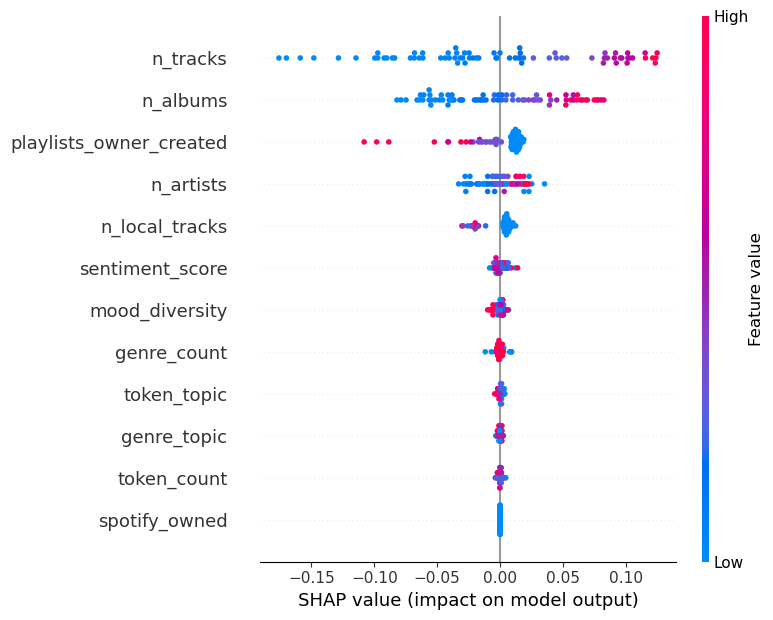

In [131]:
compute_shap_explanations(model, X_train, num_samples=75, random_seed=None, local=False, row_num=0)

  0%|          | 0/100 [00:00<?, ?it/s]

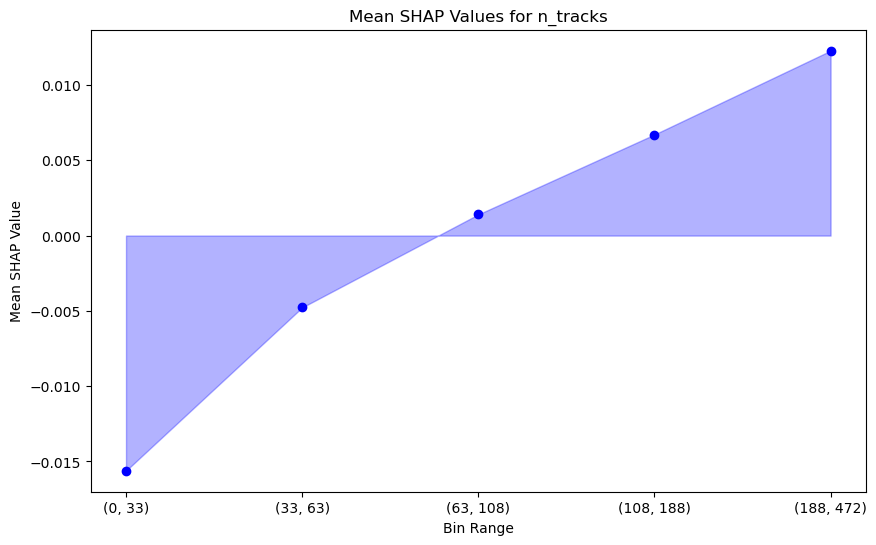

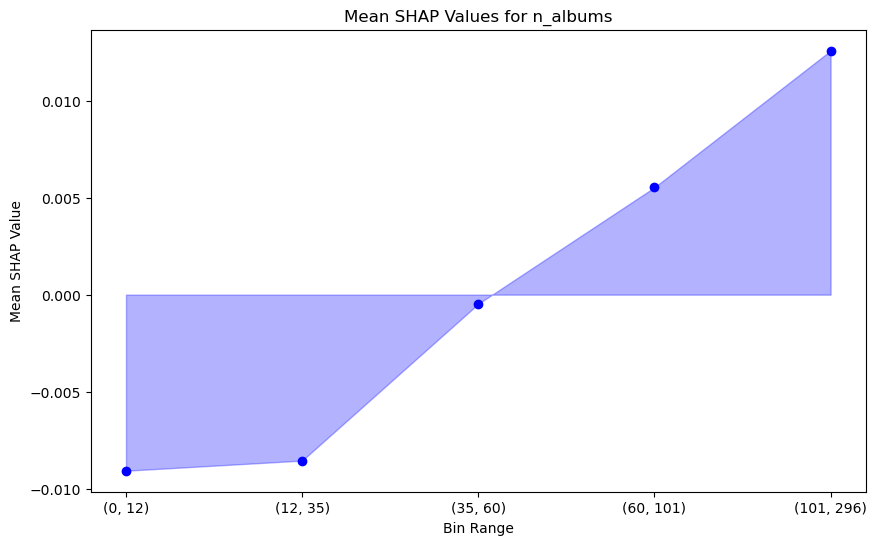

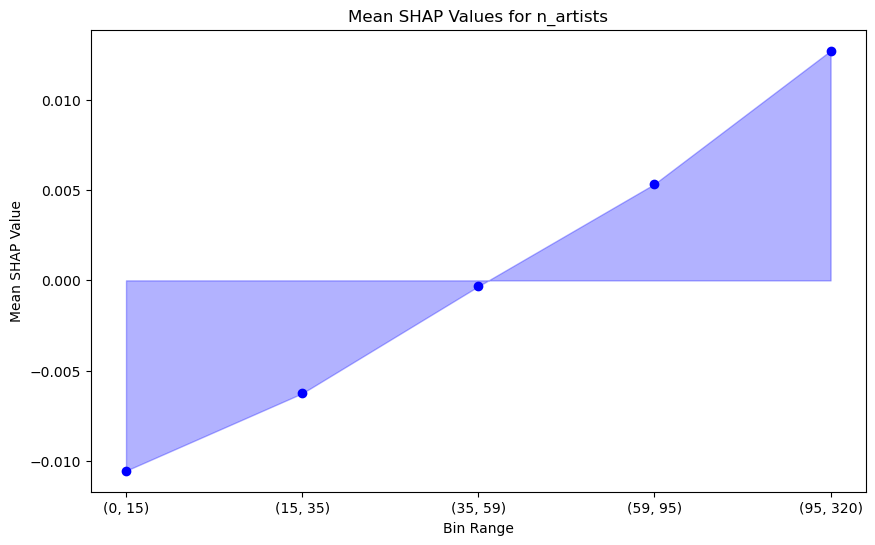

,n_tracks,n_albums,n_artists
0,0.012277,0.005533,0.012723
1,0.006710,-0.000475,-0.000330
2,0.006710,0.005533,0.005338
3,0.001404,-0.000475,-0.000330
4,0.006710,-0.000475,-0.000330
...,...,...,...
95,-0.015617,-0.008558,-0.010544
96,0.012277,0.012579,0.005338
97,0.006710,-0.008558,-0.010544
98,-0.004774,0.005533,0.005338


In [149]:
plot_shap_means(model, X_train, fill=True)

**Streaming-based success**

Definition b): A playlist is successful if it has a **high** number of *popular* or *quality* streams.

In [135]:
df = base_df.copy()

df['streams_ratio'] = df['stream30s'] / df['streams'] #highher is better
df['monthly_stream_ratio'] = df['monthly_stream30s'] / df['monthly_owner_stream30s'] #higher is better

df['success'] = (
    (df['streams_ratio'] >= df['streams_ratio'].quantile(0.65)).astype(int) +  
    (df['monthly_stream_ratio'] >= df['monthly_stream_ratio'].quantile(0.65)).astype(int)
    #(df['monthly_stream30s'] >= df['monthly_stream30s'].quantile(0.65)).astype(int) +  
    #(df['monthly_owner_stream30s'] >= df['monthly_owner_stream30s'].quantile(0.65)).astype(int)) 
    >= 1 
).astype(int)

drop_cols = ['streams', 'stream30s', 'streams_ratio','monthly_stream_ratio', 'dau', 'wau', 'mau', 'mau_previous_month', 'monthly_stream30s', 'users', 
        'monthly_owner_stream30s', 'mau_both_months', 'premium_mau_previous_month', 'premium_mau', 'skippers'] 

In [137]:
report, model, X_train = train_and_evaluate(df, drop_cols, class_weights = {0:1, 1: 1.25}, scaling=False)

              precision    recall  f1-score   support

           0       0.60      0.51      0.55     37547
           1       0.52      0.61      0.56     33181

    accuracy                           0.56     70728
   macro avg       0.56      0.56      0.56     70728
weighted avg       0.56      0.56      0.56     70728



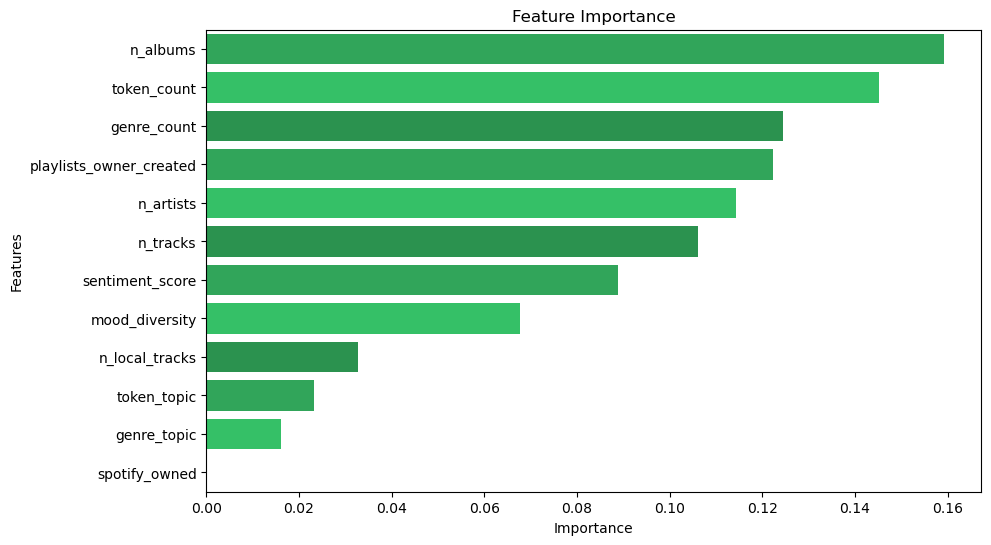

,Feature,Importance
3,n_albums,0.159307
7,token_count,0.145205
6,genre_count,0.124429
11,playlists_owner_created,0.122382
2,n_artists,0.114239
0,n_tracks,0.106075
4,sentiment_score,0.088843
5,mood_diversity,0.067687
1,n_local_tracks,0.032620
8,token_topic,0.023188


In [139]:
plot_feature_importance(model, X_train)

  0%|          | 0/75 [00:00<?, ?it/s]

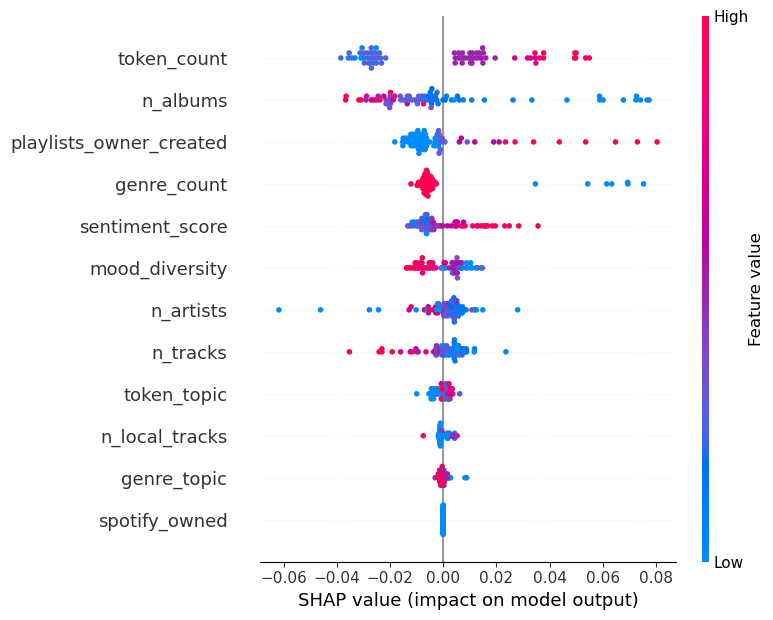

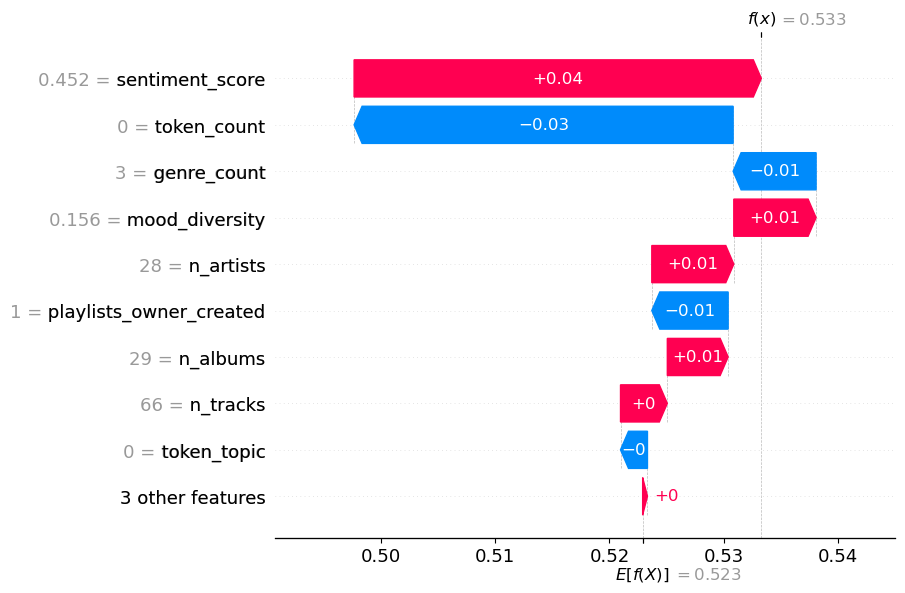

In [141]:
compute_shap_explanations(model, X_train, num_samples=75, random_seed=None, local=True, row_num=34)

  0%|          | 0/100 [00:00<?, ?it/s]

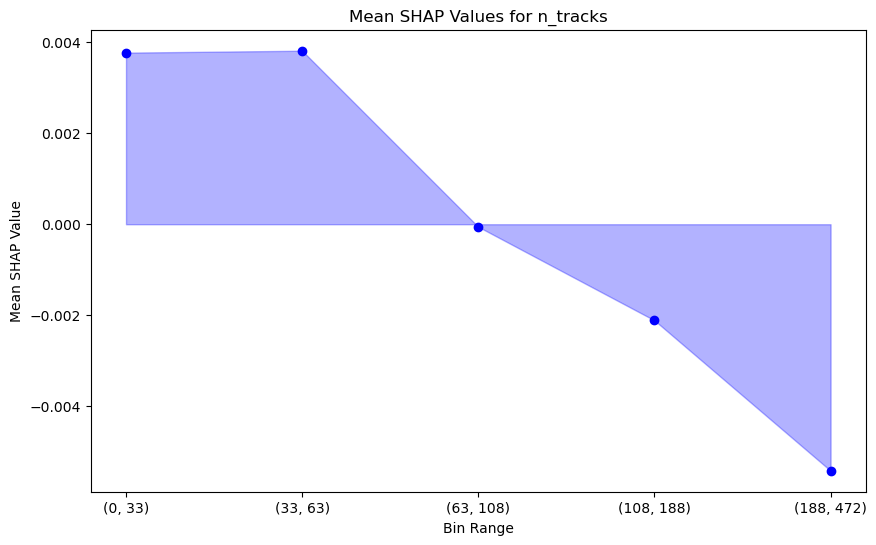

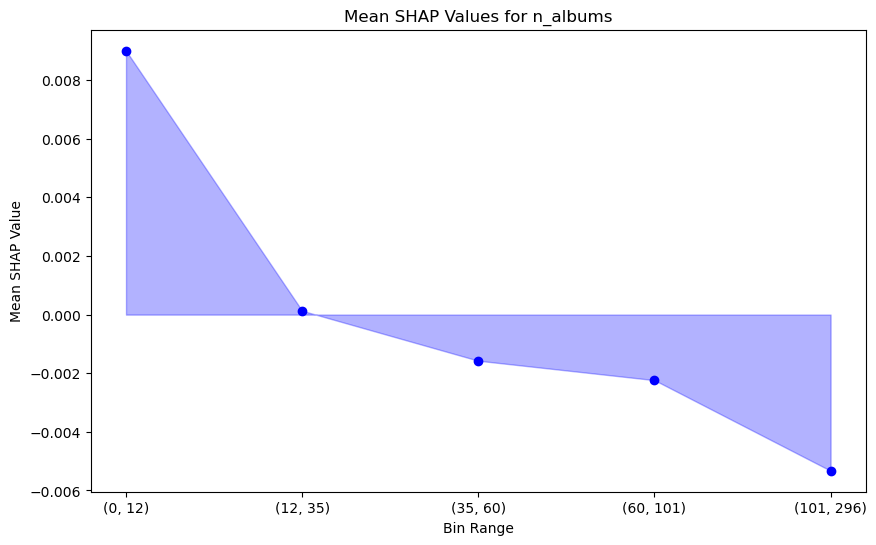

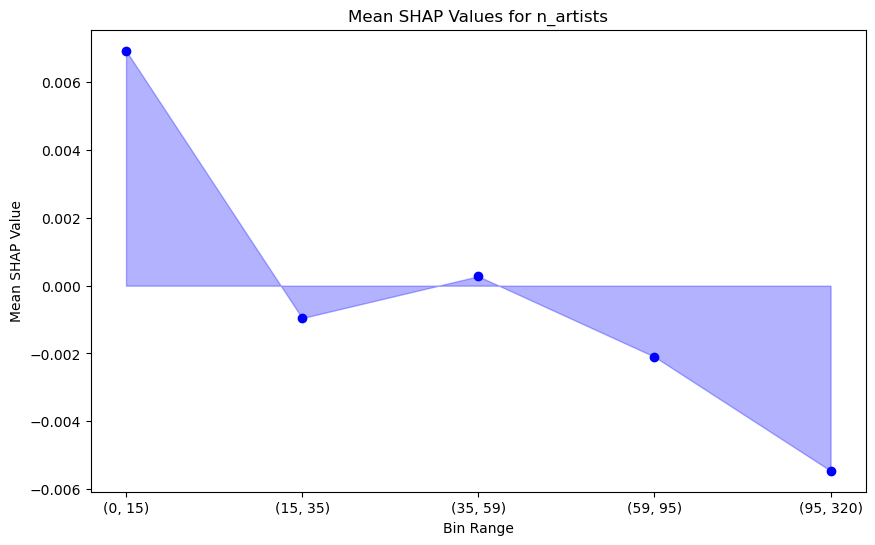

,n_tracks,n_albums,n_artists
0,-0.005415,-0.002236,-0.005459
1,-0.002111,-0.001573,0.000278
2,-0.002111,-0.002236,-0.002095
3,-0.000056,-0.001573,0.000278
4,-0.002111,-0.001573,0.000278
...,...,...,...
95,0.003770,0.000132,0.006931
96,-0.005415,-0.005328,-0.002095
97,-0.002111,0.000132,0.006931
98,0.003812,-0.002236,-0.002095


In [143]:
plot_shap_means(model, X_train, fill=True)

#### Users-based success

Definition a): A playlist is successful if it *retains* **at least 25%** of its users. (Month over Month)

In [147]:
df = base_df.copy()
df = df[df['mau_previous_month']>=5]

retention_threshold = 0.25

df["retention_rate"] = df["mau_both_months"] / df["mau_previous_month"]

df["success"] = ((df["retention_rate"] > retention_threshold)).astype(int)

drop_cols = ['streams', 'stream30s','retention_rate' ,'dau', 'wau', 'mau', 'mau_previous_month', 'monthly_stream30s', 'users', 
        'monthly_owner_stream30s', 'mau_both_months', 'premium_mau_previous_month', 'premium_mau', 'skippers'] 

In [149]:
report, model, X_train = train_and_evaluate(df, drop_cols, class_weights = {0:1, 1:2.5}, scaling=False)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7952
           1       0.53      0.45      0.48      2441

    accuracy                           0.78     10393
   macro avg       0.68      0.66      0.67     10393
weighted avg       0.76      0.78      0.77     10393



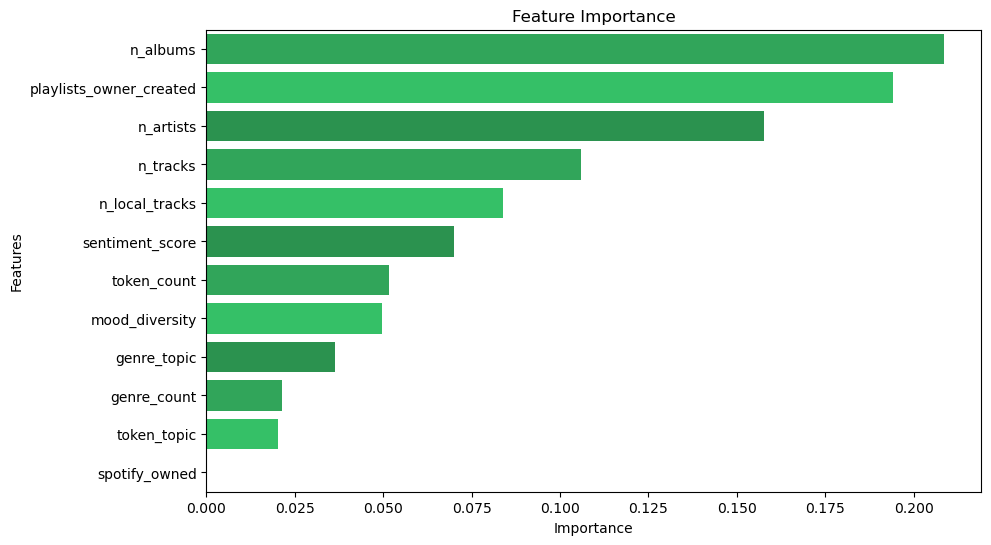

,Feature,Importance
3,n_albums,0.208746
11,playlists_owner_created,0.194183
2,n_artists,0.157719
0,n_tracks,0.105848
1,n_local_tracks,0.083961
4,sentiment_score,0.070092
7,token_count,0.051755
5,mood_diversity,0.049563
9,genre_topic,0.036488
6,genre_count,0.021369


In [151]:
plot_feature_importance(model, X_train)

  0%|          | 0/75 [00:00<?, ?it/s]

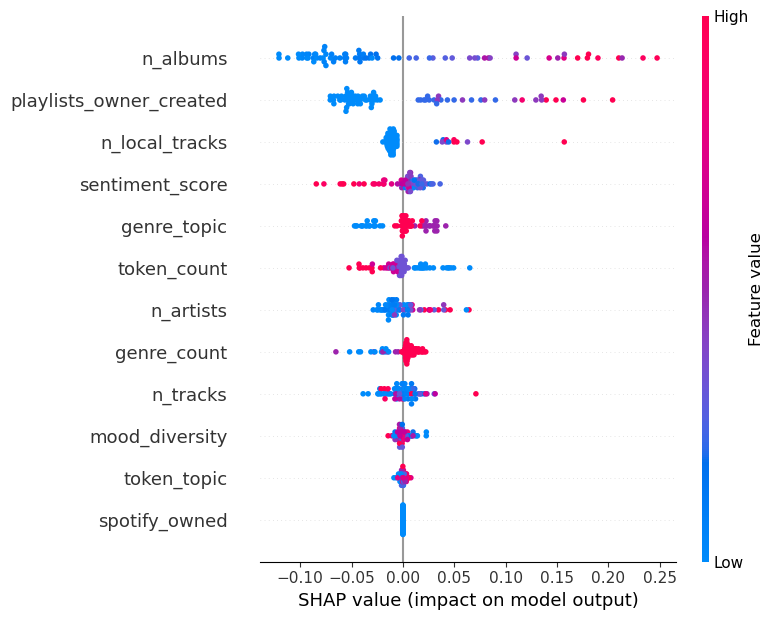

In [153]:
compute_shap_explanations(model, X_train, num_samples=75, random_seed=None, local=False, row_num=0)

**Users based success**

Definition b): A playlist is successful if active users have **increased** over time. (i.e Playlist has a high growth rate)

In [161]:
df = base_df.copy()
df = df[df['mau_previous_month']>=5]

df["growth_rate"] = (df["mau"] - df["mau_previous_month"]) / df["mau_previous_month"]
growth_threshold = 0.25

# Define success based on high growth
df["success"] = (df["growth_rate"] > growth_threshold).astype(int)

drop_cols = ['streams', 'stream30s','growth_rate' ,'dau', 'wau', 'mau', 'mau_previous_month', 'monthly_stream30s', 'users', 
        'monthly_owner_stream30s', 'mau_both_months', 'premium_mau_previous_month', 'premium_mau', 'skippers'] 

In [163]:
report, model, X_train = train_and_evaluate(df, drop_cols, class_weights = {0:1, 1:4}, scaling=False)

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      8399
           1       0.23      0.29      0.26      1994

    accuracy                           0.68     10393
   macro avg       0.52      0.53      0.52     10393
weighted avg       0.71      0.68      0.69     10393



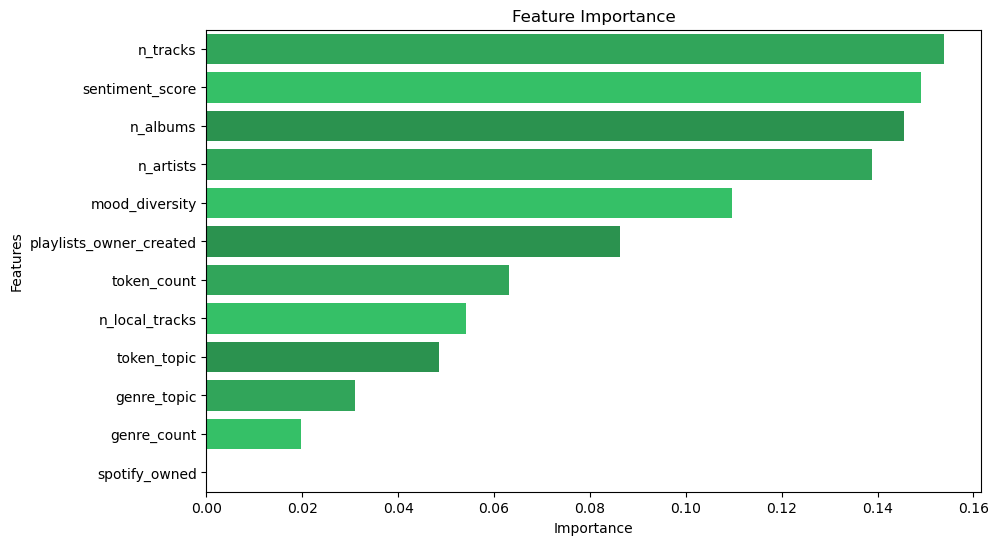

,Feature,Importance
0,n_tracks,0.153973
4,sentiment_score,0.149091
3,n_albums,0.145568
2,n_artists,0.138831
5,mood_diversity,0.109610
11,playlists_owner_created,0.086303
7,token_count,0.063184
1,n_local_tracks,0.054211
8,token_topic,0.048585
9,genre_topic,0.030937


In [164]:
plot_feature_importance(model, X_train)

  0%|          | 0/100 [00:00<?, ?it/s]

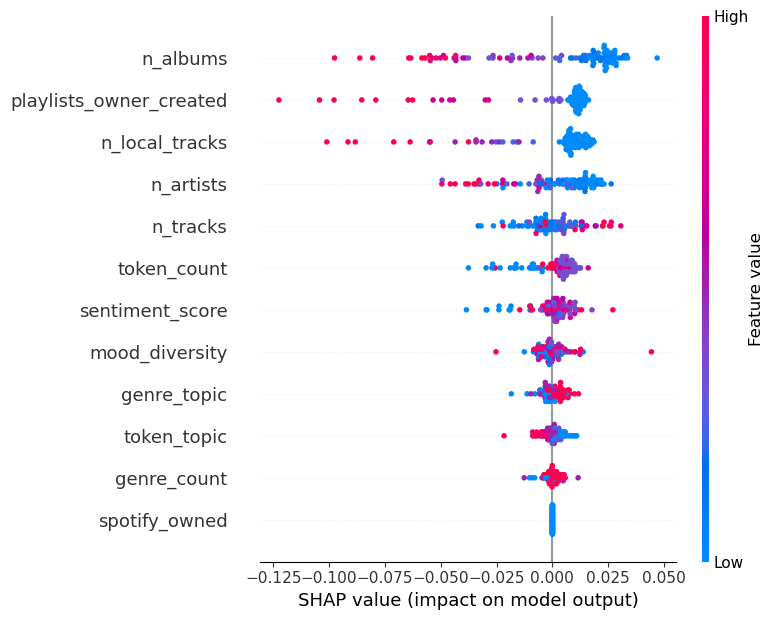

In [166]:
compute_shap_explanations(model, X_train, num_samples=100, random_seed=50, local=False, row_num=0)

**Users based success**

Definition c): A playlist is successful if it has listeners come to it frequently. **(Short-term Engagement)**

In [195]:
df = base_df.copy()
df = df[df['mau']>=3]

df["success"] = ((df['dau']>=1) & (df['wau']>=2)).astype(int)

drop_cols = ['streams', 'stream30s', 'dau', 'wau', 'mau', 'mau_previous_month', 'monthly_stream30s', 'users', 
        'monthly_owner_stream30s', 'mau_both_months', 'premium_mau_previous_month', 'premium_mau', 'skippers'] 

In [197]:
report, model, X_train = train_and_evaluate(df, drop_cols, class_weights = {0:1, 1:1.5}, scaling=False)

              precision    recall  f1-score   support

           0       0.64      0.36      0.46     14520
           1       0.45      0.73      0.56     10580

    accuracy                           0.51     25100
   macro avg       0.55      0.54      0.51     25100
weighted avg       0.56      0.51      0.50     25100



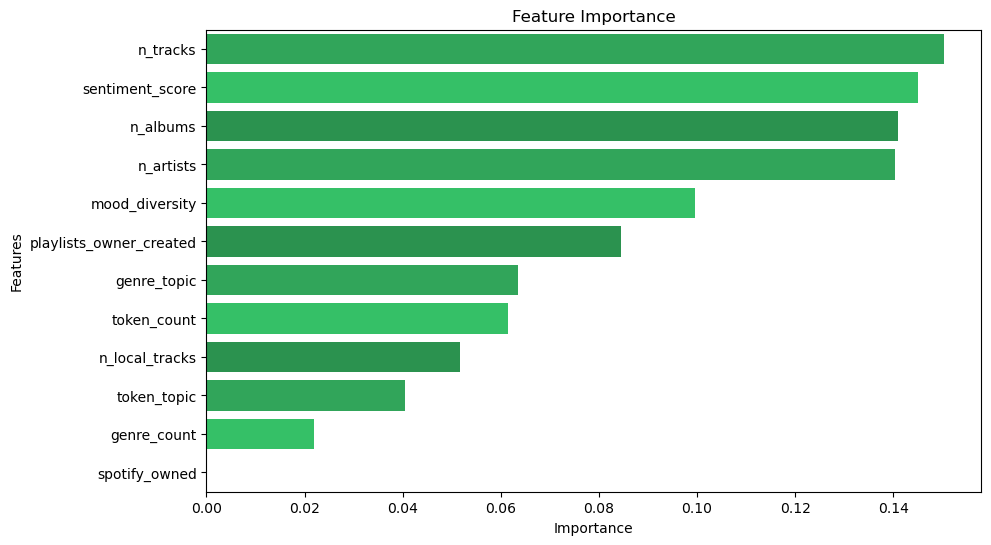

,Feature,Importance
0,n_tracks,0.150442
4,sentiment_score,0.144988
3,n_albums,0.141030
2,n_artists,0.140330
5,mood_diversity,0.099661
11,playlists_owner_created,0.084408
9,genre_topic,0.063498
7,token_count,0.061528
1,n_local_tracks,0.051684
8,token_topic,0.040439


In [199]:
plot_feature_importance(model, X_train)

  0%|          | 0/100 [00:00<?, ?it/s]

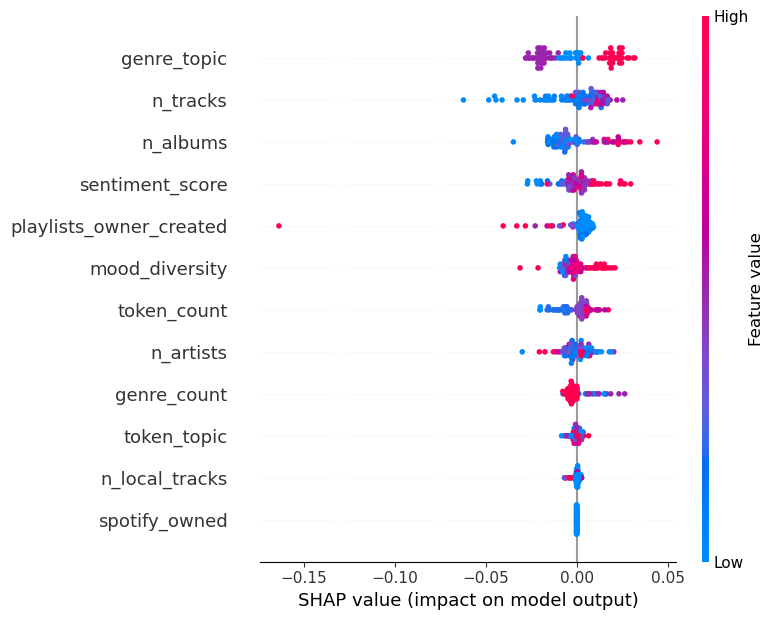

In [201]:
compute_shap_explanations(model, X_train, num_samples=100, random_seed=50, local=False, row_num=0)

### Abstract Definitions

#### a) Skipping Behaviour Based Success

A playlist is successful if no user **skipped more than 90%** of his streams today.

In [266]:
df = base_df.copy()

df = df[df['dau']>=2]

df['success'] = (
    (df['skippers'] == 0)
).astype(int)

# Drop unnecessary columns
drop_cols = ['streams', 'stream30s', 'dau', 'wau', 'mau', 
             'mau_previous_month', 'monthly_stream30s', 'users', 'monthly_owner_stream30s', 'mau_both_months', 
             'premium_mau_previous_month', 'premium_mau', 'skippers']

In [268]:
report, model, X_train = train_and_evaluate(df, drop_cols, class_weights = {0:1, 1:5}, scaling=False)

              precision    recall  f1-score   support

           0       0.84      0.67      0.74      1923
           1       0.26      0.48      0.34       464

    accuracy                           0.63      2387
   macro avg       0.55      0.58      0.54      2387
weighted avg       0.73      0.63      0.66      2387



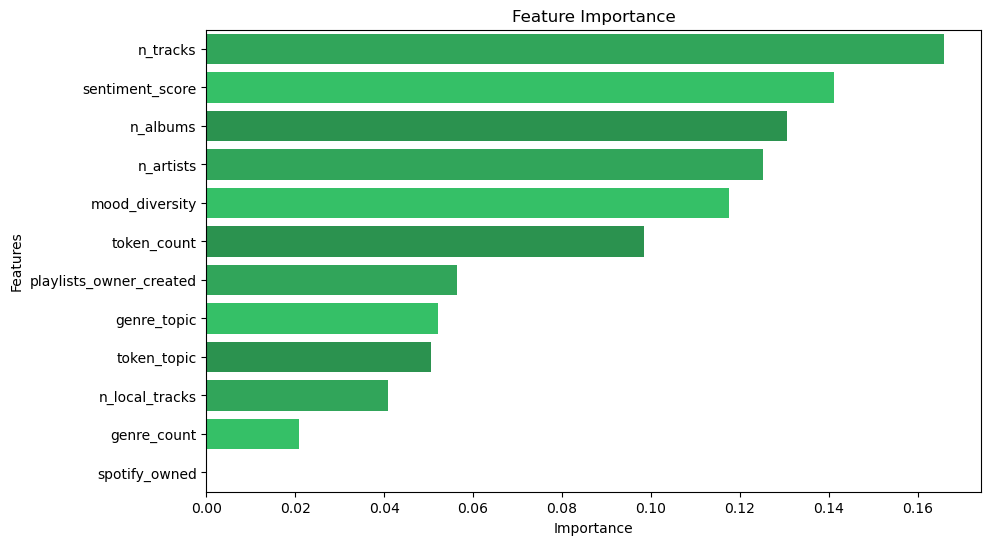

,Feature,Importance
0,n_tracks,0.166067
4,sentiment_score,0.141148
3,n_albums,0.130712
2,n_artists,0.125298
5,mood_diversity,0.117565
7,token_count,0.098525
11,playlists_owner_created,0.056394
9,genre_topic,0.052073
8,token_topic,0.050519
1,n_local_tracks,0.040797


In [269]:
plot_feature_importance(model, X_train)

  0%|          | 0/80 [00:00<?, ?it/s]

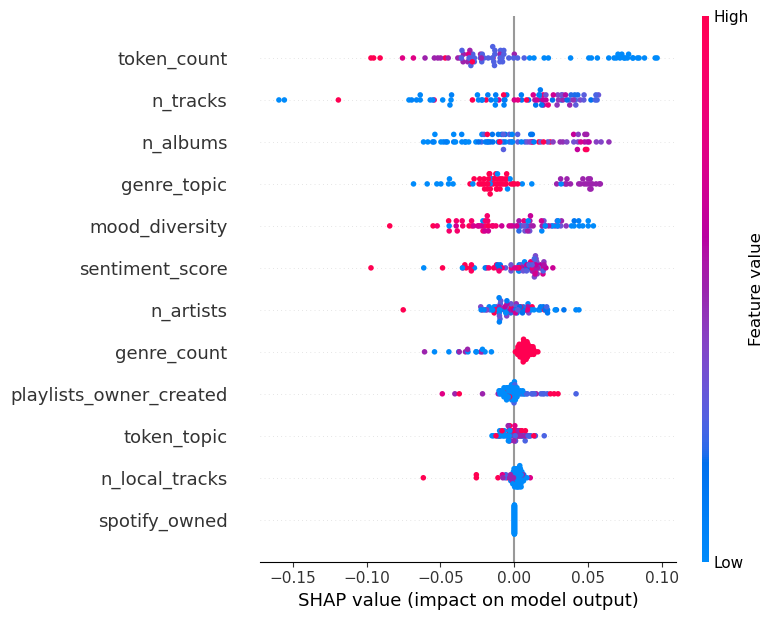

In [272]:
compute_shap_explanations(model, X_train, num_samples=80, random_seed=50, local=False, row_num=0)

#### b) Premium User based success

Definition: A playlist is successful if **premium users** are engaging with it. At least 5 premium users.

In [292]:
df = base_df.copy()

df['success'] = (
    (df['premium_mau'] >= 5)
).astype(int)

# Drop unnecessary columns
drop_cols = ['streams', 'stream30s', 'dau', 'wau', 'mau', 
             'mau_previous_month', 'monthly_stream30s', 'users', 'monthly_owner_stream30s', 'mau_both_months', 
             'premium_mau_previous_month', 'premium_mau', 'skippers']

In [293]:
report, model, X_train = train_and_evaluate(df, drop_cols, class_weights = {0:1, 1:7.5}, scaling=False)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     64593
           1       0.19      0.43      0.26      6135

    accuracy                           0.79     70728
   macro avg       0.56      0.63      0.57     70728
weighted avg       0.87      0.79      0.83     70728



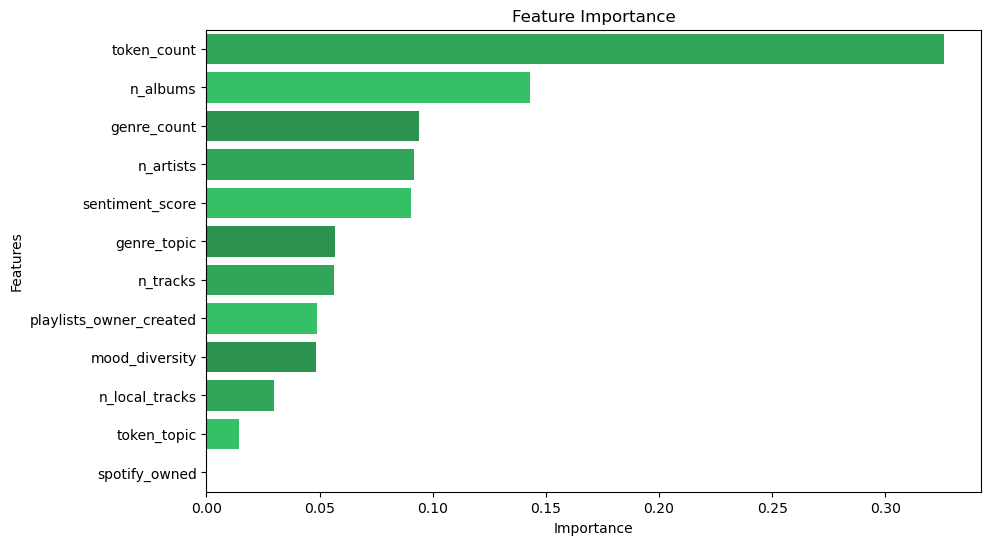

,Feature,Importance
7,token_count,0.326083
3,n_albums,0.142929
6,genre_count,0.094135
2,n_artists,0.091811
4,sentiment_score,0.090407
9,genre_topic,0.056711
0,n_tracks,0.056548
11,playlists_owner_created,0.048658
5,mood_diversity,0.048517
1,n_local_tracks,0.029901


In [294]:
plot_feature_importance(model, X_train)

  0%|          | 0/80 [00:00<?, ?it/s]

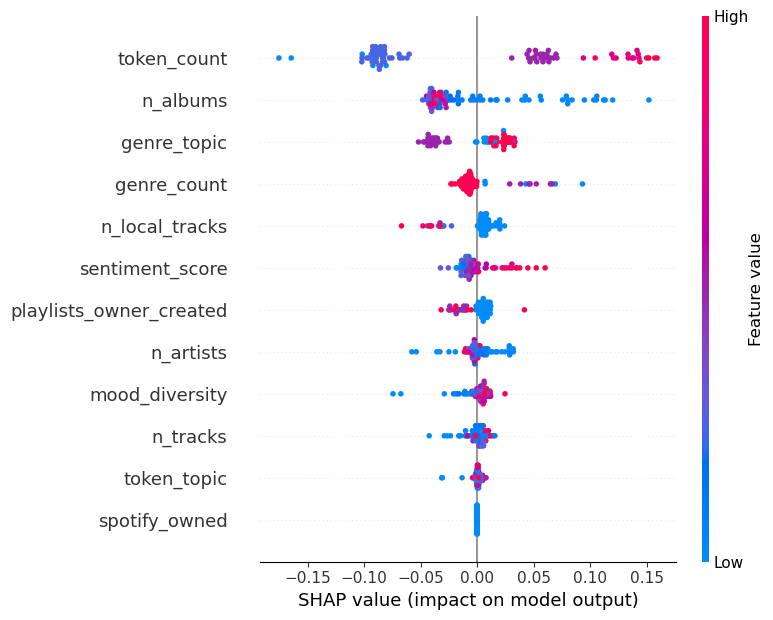

In [295]:
compute_shap_explanations(model, X_train, num_samples=80, random_seed=50, local=False, row_num=0)

*extreme case:* A playlist is successful if **all** its users are premium.

In [302]:
df = base_df.copy()
df = df[df['mau']>=2]

df['success'] = (
    (df['premium_mau']/df['mau'] ==1)
).astype(int)

# Drop unnecessary columns
drop_cols = ['streams', 'stream30s', 'dau', 'wau', 'mau', 
             'mau_previous_month', 'monthly_stream30s', 'users', 'monthly_owner_stream30s', 'mau_both_months', 
             'premium_mau_previous_month', 'premium_mau', 'skippers']

In [304]:
report, model, X_train = train_and_evaluate(df, drop_cols, class_weights = {0:1, 1:1}, scaling=False)

              precision    recall  f1-score   support

           0       0.57      0.61      0.59     36547
           1       0.55      0.50      0.52     34098

    accuracy                           0.56     70645
   macro avg       0.56      0.56      0.56     70645
weighted avg       0.56      0.56      0.56     70645



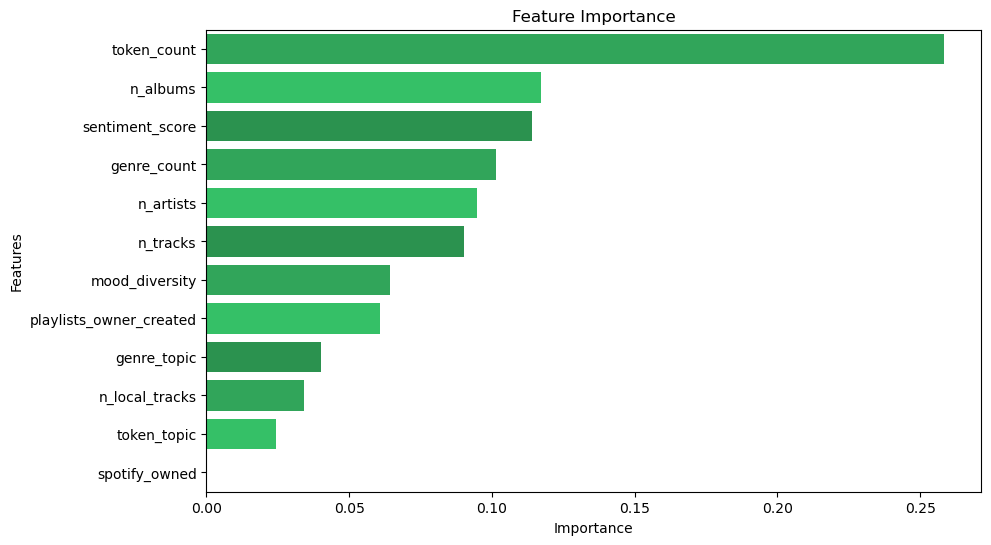

,Feature,Importance
7,token_count,0.258537
3,n_albums,0.117041
4,sentiment_score,0.113916
6,genre_count,0.101298
2,n_artists,0.094935
0,n_tracks,0.090377
5,mood_diversity,0.064329
11,playlists_owner_created,0.060873
9,genre_topic,0.039989
1,n_local_tracks,0.034213


In [305]:
plot_feature_importance(model, X_train)

  0%|          | 0/80 [00:00<?, ?it/s]

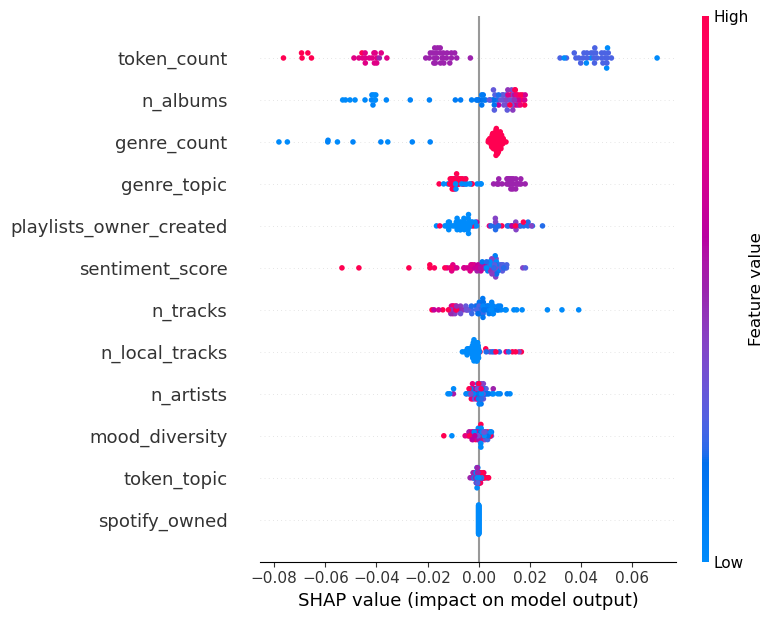

In [306]:
compute_shap_explanations(model, X_train, num_samples=80, random_seed=50, local=False, row_num=0)

In [240]:
#Experiment - Playlists that help conversion from free to premium version

df = base_df.copy()
df = df[df['mau']>=2]
df = df[df['mau_previous_month']>=2]

df["premium_ratio_change"] = (df["premium_mau"] / df["mau"]) / (df["premium_mau_previous_month"] / df["mau_previous_month"])

df['success'] = (
    (df["premium_ratio_change"] > 1)
).astype(int)

df.drop(columns = ['premium_ratio_change'], inplace=True)

#df = oversample_with_smote(df)

# Drop unnecessary columns
drop_cols = ['streams', 'stream30s', 'dau', 'wau', 'mau',
             'mau_previous_month', 'monthly_stream30s', 'users', 'monthly_owner_stream30s', 'mau_both_months', 
             'premium_mau_previous_month', 'premium_mau', 'skippers']

In [242]:
report, model, X_train = train_and_evaluate(df, drop_cols, class_weights = {0:1, 1:3}, scaling=False)

              precision    recall  f1-score   support

           0       0.78      0.74      0.76     29712
           1       0.27      0.32      0.29      9275

    accuracy                           0.64     38987
   macro avg       0.52      0.53      0.52     38987
weighted avg       0.66      0.64      0.65     38987



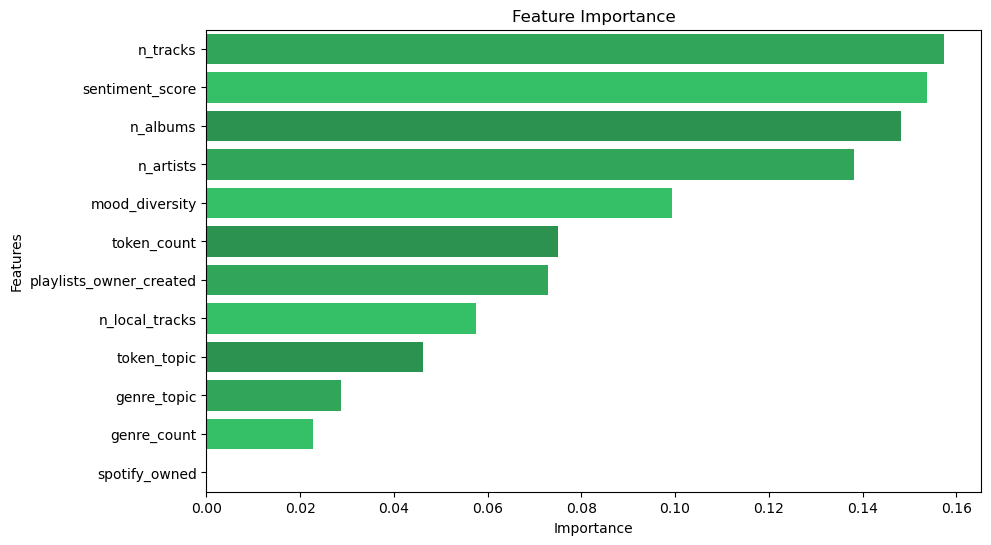

,Feature,Importance
0,n_tracks,0.157483
4,sentiment_score,0.153688
3,n_albums,0.148225
2,n_artists,0.138164
5,mood_diversity,0.099378
7,token_count,0.074989
11,playlists_owner_created,0.072962
1,n_local_tracks,0.057491
8,token_topic,0.046250
9,genre_topic,0.028613


In [243]:
plot_feature_importance(model, X_train)

  0%|          | 0/80 [00:00<?, ?it/s]

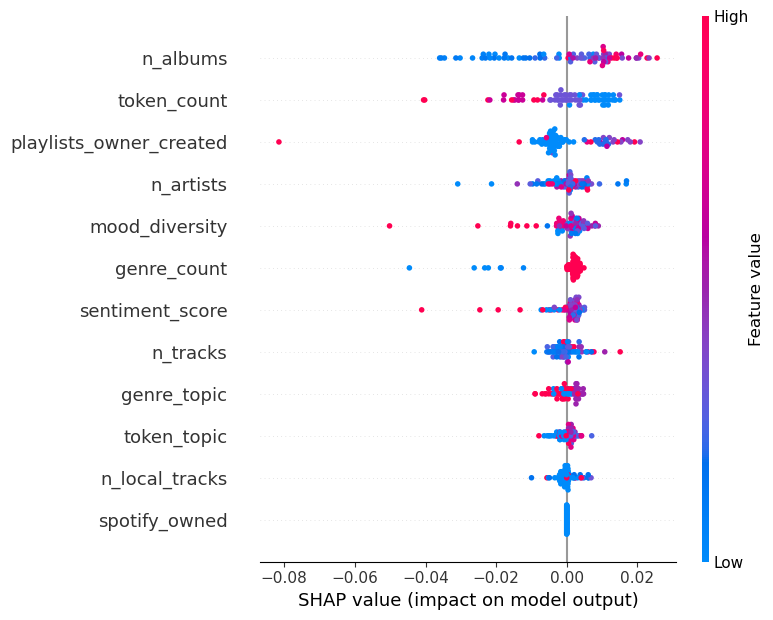

In [244]:
compute_shap_explanations(model, X_train, num_samples=80, random_seed=50, local=False, row_num=0)

### Combined Model

**Definition:** A playlist is successful it meets at least 3 of the 5 criterions

In [324]:
df = base_df.copy()

df = df[df['mau']>=3]
df = df[df['mau_previous_month']>=5]

retention_threshold = 0.25

df['streams_ratio'] = df['stream30s'] / df['streams']
df['monthly_stream_ratio'] = df['monthly_stream30s'] / df['monthly_owner_stream30s']
df["retention_rate"] = df["mau_both_months"] / df["mau_previous_month"]

df['success'] = (
    (
        (df['streams_ratio'] >= df['streams_ratio'].quantile(0.65)).astype(int) +  
        (df['monthly_stream_ratio'] >= df['monthly_stream_ratio'].quantile(0.65)).astype(int) +
        (df["retention_rate"] > retention_threshold).astype(int) +
        (df['skippers'] == 0).astype(int) +  # Explicitly convert to int
        (df['premium_mau'] >= 5).astype(int)
    ) >= 3
).astype(int)


drop_cols = ['streams', 'stream30s', 'streams_ratio','retention_rate','monthly_stream_ratio', 'dau', 'wau', 'mau', 'mau_previous_month', 'monthly_stream30s', 'users', 
        'monthly_owner_stream30s', 'mau_both_months', 'premium_mau_previous_month', 'premium_mau', 'skippers'] 

In [326]:
report, model, X_train = train_and_evaluate(df, drop_cols, class_weights = {0:1, 1:2.5}, scaling=False)

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      7486
           1       0.36      0.30      0.33      2537

    accuracy                           0.69     10023
   macro avg       0.57      0.56      0.56     10023
weighted avg       0.67      0.69      0.68     10023



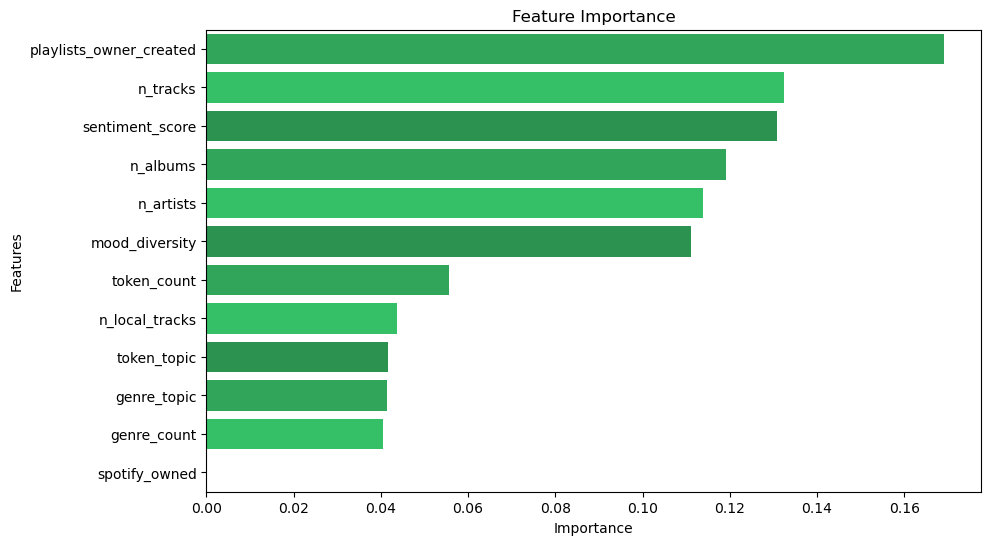

,Feature,Importance
11,playlists_owner_created,0.169247
0,n_tracks,0.132461
4,sentiment_score,0.130883
3,n_albums,0.119238
2,n_artists,0.113929
5,mood_diversity,0.111085
7,token_count,0.055586
1,n_local_tracks,0.043735
8,token_topic,0.041697
9,genre_topic,0.041485


In [328]:
plot_feature_importance(model, X_train)

  0%|          | 0/80 [00:00<?, ?it/s]

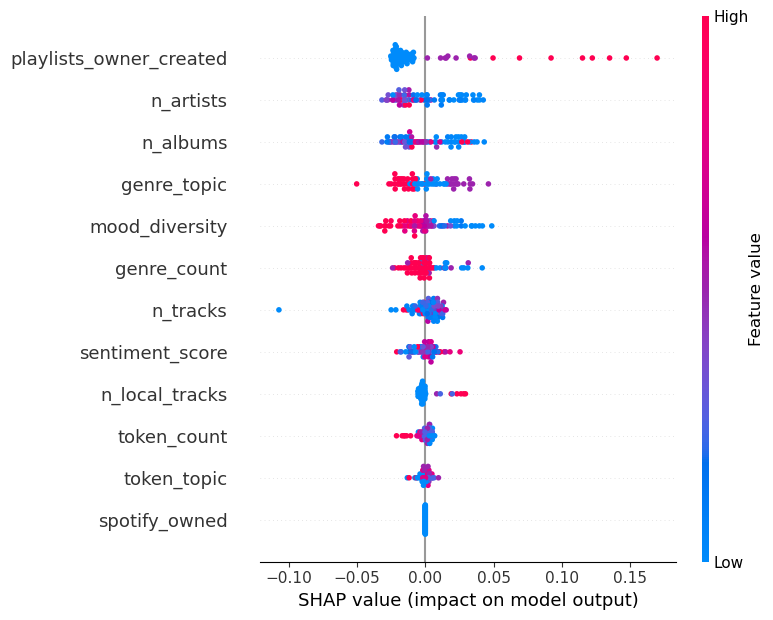

In [330]:
compute_shap_explanations(model, X_train, num_samples=80, random_seed=50, local=False, row_num=0)

**Comments**

- Streaming-based Success:
Focused curation wins: Fewer tracks lead to higher quality streams, while diverse albums broaden appeal.

- User Retention:
Longevity through depth: A large track library and album variety keep users engaged over time.

- Premium User Growth:
Value through volume: Extensive track and album selections attract and retain premium subscribers.

- Reduced Skipping:
Variety prevents skips: A wide range of tracks and albums increases listener satisfaction and reduces skipping.

**Suggestions**

For broad, lasting appeal, one should build playlists with extensive libraries.

For concentrated impact, the focus should be on tighter, more selective tracklists.